# *First and Second Assignment*
First
- Generate Interpolation Function;
- Interpolate a a gaussian and compare the error to real Gaussian data;
- Find the cumulative of the interpolated function and compare to the real cumulative;

Second
- Generate a sample using linear interpolation in the cumulative points;

In [1]:
import numpy as np
import scipy as sc
from scipy.special import erf
import random as rd
import matplotlib.pyplot as plt
import math

# Interpolation Fcuntion

We want to generate a linear interpolation function.

In [2]:
class LinearInterp:
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.cumulative_data = None
   

    def do_interp(self, x):
        for a in range(0, len(self.y_data)-1):
            if x >= self.x_data[a] and x <= self.x_data[a+1]:
                dy = self.y_data[a+1] - self.y_data[a]
                dx = self.x_data[a+1] - self.x_data[a]
                coef_b = self.y_data [a] - (self.x_data[a] * dy) / dx  
                coef_a = dy / dx
                new_point = coef_b + x * coef_a
                return [new_point, (coef_a, coef_b),(self.x_data[a], self.x_data[a+1])]
    
    def do_cumulative(self, a, b):
        cumulative = 0
        for x in self.x_data:
            if x>=a and x<=b:
                result = self.do_interp(x)
                cumulative += result[2][1] ** 2 * result[1][0] /2 + result[2][1]*result[1][1] - result[2][0] ** 2 * result[1][0] /2 - result[2][0]*result[1][1]  
        return [cumulative, result[1][0], result[1][1]]

#This function checks if I generated one point before (if the cumulative data is empty. If I didnt, it computes the cumulative for all the knots).
    def generate_random_g_point(self, a, b):
        c = rd.uniform(0,1)
        if self.cumulative_data == None:
            temporary_list = []
            for knot in range(0,len(self.x_data)-1):
                temporary_list.append(self.do_cumulative(a, self.x_data[knot])[0])
            self.cumulative_data = temporary_list
        for knot in range(0,len(self.x_data)-1):
            cumulative_i = self.cumulative_data[knot]
            if cumulative_i >= c:
                cumulative_j = self.do_cumulative(a, self.x_data[knot+1])[0]
                dy = self.x_data[knot+1] - self.x_data[knot]
                dx = cumulative_j - cumulative_i
                coef_b = self.x_data[knot] - (cumulative_i * dy) / dx  
                coef_a = dy / dx
                new_point = coef_b + c * coef_a
                return [new_point, (coef_a, coef_b),(self.x_data[a], self.x_data[a+1]), c]


### Simple Test with a parabolic function 

Let's us first test our interpolation with a quadratic function.

In [3]:
x = [0,1,2,3,4]
y = [a**2 for a in x]

myobj = LinearInterp(x,y)
n_p, coef_a, coef_b = myobj.do_interp(2.5)
print(f"Interpolated Point :{n_p}")
print(f"Real Point {2.5**2}")

Interpolated Point :6.5
Real Point 6.25


### Test With a Gaussian Function and Error plot

Now, we test our interpolated function with a Gaussian function.

In [4]:
mu = 0
sigma = 1
interval_init = -5
interval_end = 5
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) * (1/ (np.sqrt(2 * np.pi)*sig))

def gaussian_cdf(b, mu, sig):
    arg = (b - mu)/(np.sqrt(2) * sig)
    return 1/2 * (1 + erf(arg))


x = np.linspace(interval_init,interval_end, 500)
y = [gaussian(a, mu,sigma) for a in x]
myobj = LinearInterp(x,y)

err_list = []
points_int = []
for a in range (0,100):
    point = rd.uniform(min(x),max(x))
    n_p = myobj.do_interp(point)
    err_list.append(abs(((n_p[0] - gaussian(point, mu, sigma)))))
    points_int.append(n_p[0])

Text(0, 0.5, ' Absolute Error')

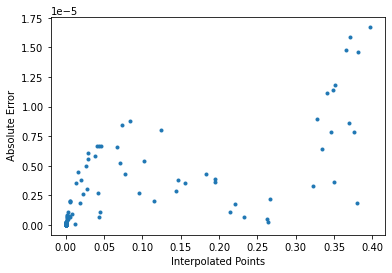

In [5]:
plt.plot(points_int, err_list, '.')
plt.xlabel('Interpolated Points')
plt.ylabel(' Absolute Error')


## Cumulative Gaussian Test

Here, we calculate the cumulative function from the interpolated probability and then compare to the real values of the cumulative from a Gaussian function.

Text(0, 0.5, ' Interpolated Cumulative Error')

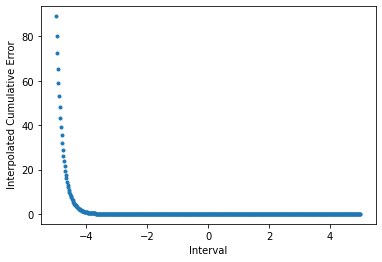

In [6]:
cdf_int = []
cdf_real = []
cdf_err = []
interval = np.linspace(interval_init,interval_end, 500)
for a in interval:
    my_cdf = myobj.do_cumulative(-5,a)[0]
    g_cdf = gaussian_cdf(a,mu,sigma)
    cdf_int.append(my_cdf)
    cdf_real.append(g_cdf)
    cdf_err.append(abs((my_cdf - g_cdf)/g_cdf)*100)
plt.plot(interval, cdf_err, '.')
plt.xlabel('Interval')
plt.ylabel(' Interpolated Cumulative Error')

## Sampler from the Cumulative

We have a cumulative function that depends on $x$. We interpolated the proabbility and integrated to get the cumulative, so now we have a set of points $\{x, C(x)\}$. We can inverte this relations, such that we interpolate $\{C, x(C)\}$, so we are now able to generate points distributed by the gaussian, using the cumulative function, which is uniform and can be genarated by ````rd.uniform()````.

In [10]:

##My sampler points, represented by sample

sample = []
for a in range (0,10000):
    new_sample_p = myobj.generate_random_g_point(interval_init, interval_end)
    sample.append(new_sample_p[0])




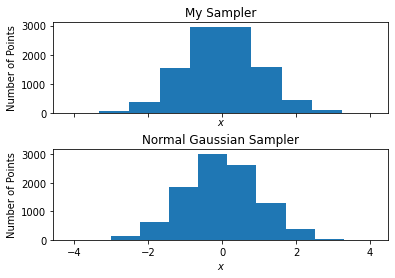

In [11]:
from scipy.stats import truncnorm

##Function to generate gaussian points from a definite interval.

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
real_gauss = get_truncated_normal(mean=0, sd=1, low=interval_init, upp=interval_end)


## Plot of the results
fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(sample,        )
ax[1].hist(real_gauss.rvs(10000))

ax[0].set_title('My Sampler')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Number of Points')

ax[1].set_xlabel('$x$')
ax[1].set_ylabel('Number of Points')
ax[1].set_title('Normal Gaussian Sampler')

plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)
plt.show()